# Projeto Agro 2026 - Sistema Inteligente de Monitoramento e Previsão de Produtividade Agrícola

## 1. O Problema (Business Case)

Este projeto visa reduzir o desperdício de insumos em fazendas de soja, prevendo janelas de seca e recomendando a irrigação precisa.

## 2. O Pipeline de Dados (Data Engineering)

Fonte A: Dados climáticos (temperatura, umidade) via API.

Fonte B: NDVI (Índice de Vegetação) extraído de imagens de satélite (Sentinel-2).

Armazenamento: Banco de dados leve como SQLite ou salvo em formato de dados eficientes como Parquet.

## 3. A Inteligência (Data Science + AI)

Machine Learning: Utilização de modelo de séries temporais (como Prophet ou XGBoost) para prever a produtividade.

IA Generativa: Criação de um "Agente Agrônomo" usando a API, com o objetivo de escrever o plano de ação personalizado para o cliente agro.


## 4. A Entrega (Visualização)

Cração de um dashboard no Streamlit para permitir que qualquer pessoa interaja com o projeto através de um link.

## 1.

### Passo 1: Definindo a Região


#### Cidade: Ribeirão Preto, SP

#### Coordenadas Aproximadas: Latitude -21.17, Longitude -47.81

#### Fonte de Dados: NASA POWER API.


Considerada a "Capital Brasileira do Agronegócio", a região escolhida para desenvolver este projeto é a cidade brasileira de Ribeirão Preto, localizada no estado de São Paulo e o objeto de trabalho será a cana-de-açúcar enquanto commodity, pois com seu ciclo longo e dados históricos abundantes ela é perfeita para modelos de previsão.


## 2. Fonte A

### Script de Captura de Dados via NASA POWER API





In [2]:
import requests
import pandas as pd

# Configurações da Requisição
LAT = -21.1775
LON = -47.8103
START_DATE = "20100101"
END_DATE = "20251231" # Ajustado para o final de 2025

# Parâmetros: T2M (Temp a 2m), PRECTOTCORR (Chuva), RH2M (Umidade Relativa), 
# ALLSKY_SFC_SW_DWN(Radiação Solar), GWETTOP(Umidade Solo)
params = "T2M,PRECTOTCORR,RH2M,ALLSKY_SFC_SW_DWN,GWETTOP"

url = (f"https://power.larc.nasa.gov/api/temporal/daily/point?"
       f"parameters={params}&community=AG&longitude={LON}&latitude={LAT}"
       f"&start={START_DATE}&end={END_DATE}&format=JSON")

print("Solicitando dados à NASA POWER API...")
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    # Transformando o dicionário de parâmetros em um DataFrame do Pandas
    df = pd.DataFrame(data['properties']['parameter'])
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Data'
    
    # Renomeando para facilitar a leitura
    df.columns = ['Temperatura_Media', 'Chuva_mm', 'Umidade_Relativa', 'Radiação_Solar', 'Umidade_Solo']
    
    print("Sucesso! Primeiras 5 linhas do seu dataset:")
    print(df.head())
    
    # Salvar para o próximo passo
    df.to_csv("dados_climaticos_ribeirao.csv")
else:
    print(f"Erro na requisição: {response.status_code}")

Solicitando dados à NASA POWER API...
Sucesso! Primeiras 5 linhas do seu dataset:
            Temperatura_Media  Chuva_mm  Umidade_Relativa  Radiação_Solar  \
Data                                                                        
2010-01-01              23.10      3.21             86.77           19.88   
2010-01-02              24.03      2.58             82.35           20.74   
2010-01-03              24.31      0.04             80.08           29.13   
2010-01-04              25.07      0.00             71.81           27.76   
2010-01-05              24.32     31.13             81.57           24.81   

            Umidade_Solo  
Data                      
2010-01-01          0.94  
2010-01-02          0.93  
2010-01-03          0.92  
2010-01-04          0.91  
2010-01-05          0.95  


Descrevendo o uso dos parâmetros:

A cana-de-açúcar não cresce apenas com "chuva e temperatura". Ela depende da energia que recebe e da água que perde.

ALLSKY_SFC_SW_DWN (Radiação Solar): É o "combustível" da fotossíntese. Sem sol, a planta não acumula açúcar (sacarose).

GWETTOP (Umidade da Camada Superficial do Solo): Mais importante que a chuva isolada, pois indica se a planta consegue absorver água.

## Análise Exploratória do dados gerados

In [3]:
# Resumo Estatístico
df = pd.read_csv("dados_climaticos_ribeirao.csv", index_col='Data', parse_dates=True)

print("Resumo das variáveis climáticas (2010-2025):")
display(df.describe())

Resumo das variáveis climáticas (2010-2025):


,Temperatura_Media,Chuva_mm,Umidade_Relativa,Radiação_Solar,Umidade_Solo
count,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000
mean,22.949584,3.120568,67.155992,18.825207,0.624904
std,2.898387,5.775340,16.065959,14.372751,0.205859
min,9.910000,0.000000,18.190000,-999.000000,0.180000
25%,21.390000,0.000000,56.077500,15.727500,0.497500
50%,23.160000,0.310000,70.180000,18.915000,0.650000
75%,24.710000,3.650000,80.050000,22.980000,0.780000
max,33.240000,44.880000,94.650000,31.700000,0.980000


## Limpeza de dados

In [4]:
import numpy as np

# Substituir os códigos de erro da NASA (-999) por NaN real do Pandas
df.replace(-999, np.nan, inplace=True)

# Verificar quantos dados nulos temos agora em cada coluna
print("Dados nulos encontrados:")
print(df.isnull().sum())

# Limpeza de Outliers Extremos (Radiação Solar não pode ser negativa)
# Vamos garantir que Radiação e Umidade do Solo estejam em intervalos lógicos
df.loc[df['Radiação_Solar'] < 0, 'Radiação_Solar'] = np.nan

# Imputação: Preencher buracos usando Interpolação Linear 
# (Ele traça uma linha entre o valor anterior e o próximo, ideal para séries temporais)
df = df.interpolate(method='linear')

Dados nulos encontrados:
Temperatura_Media    0
Chuva_mm             0
Umidade_Relativa     0
Radiação_Solar       1
Umidade_Solo         0
dtype: int64


In [5]:
# Agrupando por ano para ver se o total acumulado de chuva faz sentido
chuva_anual = df.resample('Y')['Chuva_mm'].sum()
print(chuva_anual)

Data
2010-12-31    1110.53
2011-12-31    1424.01
2012-12-31    1209.71
2013-12-31    1297.25
2014-12-31     792.09
2015-12-31    1287.37
2016-12-31    1264.99
2017-12-31    1165.67
2018-12-31    1379.46
2019-12-31    1162.73
2020-12-31     991.92
2021-12-31     923.53
2022-12-31    1254.78
2023-12-31    1160.71
2024-12-31    1041.90
2025-12-31     769.95
Freq: A-DEC, Name: Chuva_mm, dtype: float64



Durante a EDA, identifiquei flags de erro (-999) nativas da NASA POWER API e apliquei técnicas de interpolação linear para manter a integridade da série temporal, garantindo que o modelo não fosse enviesado por ruídos de captura.

Também idenfiquei um volume de chuva aquém da região em questão. Após pesquisa, identifiquei que há uma diferença de dados de satélite em relação a estações em solo. A NASA faz sua medição utilizando um sistema de média de grade de cerca de 50km x 50km, sendo assim se em um ponto dentro desses 50x50 choveu 100mm e em outro ponto choveu 1mm, para a NASA o dado entra como a média dentro dessa célula. Realizando agrupamento, validei que a média anual está dentro dos padrões.

## Gráfico da Média de Temperatura e Distribuição Mensal de Chuvas

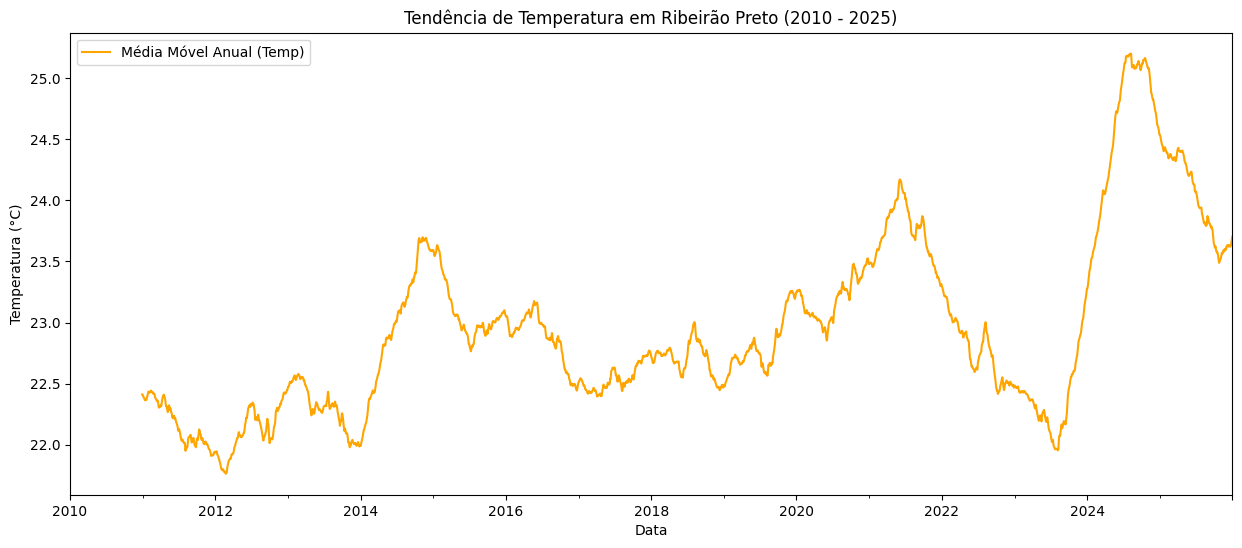

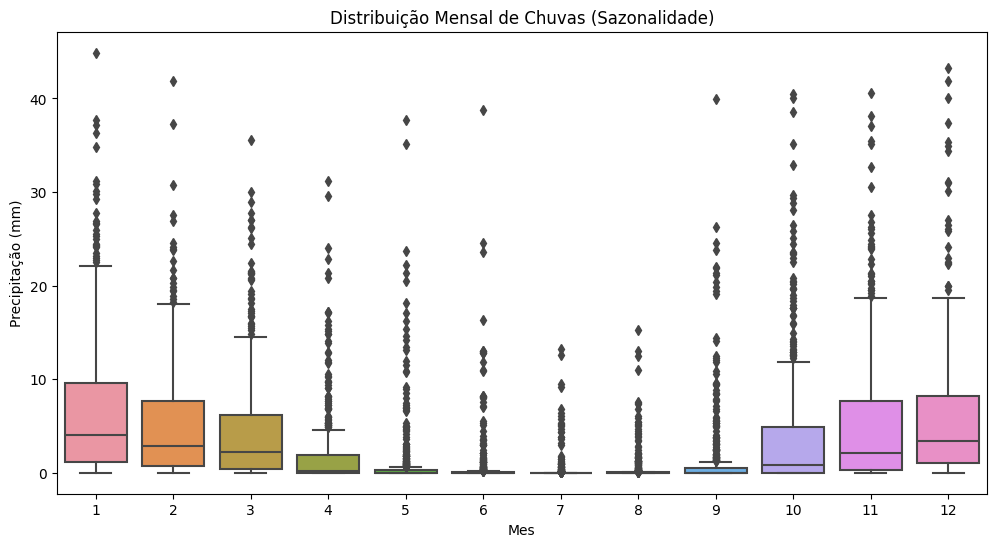

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualização de Tendências de Longo Prazo
plt.figure(figsize=(15, 6))
df['Temperatura_Media'].rolling(window=365).mean().plot(label='Média Móvel Anual (Temp)', color='orange')
plt.title('Tendência de Temperatura em Ribeirão Preto (2010 - 2025)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

# Análise de Sazonalidade de Chuvas (Boxplot Mensal)
df['Mes'] = df.index.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Mes', y='Chuva_mm', data=df)
plt.title('Distribuição Mensal de Chuvas (Sazonalidade)')
plt.ylabel('Precipitação (mm)')
plt.show()

O primeiro gráfico nos ajuda a identificar períodos de seca ao longo dos anos enquanto o segundo gráfico fornece a distribuição mensal das chuvas ao longos dos meses. Isso pode ajudar o agricultor a tomar decições importantes.

## Resumo Anual

In [8]:
# Criando o resumo anual para o modelo
resumo_anual = df.resample('Y').agg({
    'Chuva_mm': 'sum',
    'Temperatura_Media': 'mean',
    'Radiação_Solar': 'mean',
    'Umidade_Solo': 'mean'
})

# Criando a métrica de "Dias Secos" (Opcional, mas muito avançado para o portfólio)
resumo_anual['Dias_Secos'] = df['Chuva_mm'].resample('Y').apply(lambda x: (x < 1.0).sum())

display(resumo_anual)

,Chuva_mm,Temperatura_Media,Radiação_Solar,Umidade_Solo,Dias_Secos
Data,,,,,
2010-12-31,1110.53,22.412082,19.252493,0.638603,213
2011-12-31,1424.01,21.939014,18.831397,0.705205,214
2012-12-31,1209.71,22.460464,19.230792,0.676093,223
2013-12-31,1297.25,21.991671,18.375562,0.716219,204
2014-12-31,792.09,23.590000,19.745671,0.542877,246
2015-12-31,1287.37,23.057562,18.173014,0.671507,195
2016-12-31,1264.99,22.510191,18.963279,0.683852,202
2017-12-31,1165.67,22.728521,19.220219,0.626137,218
2018-12-31,1379.46,22.479616,18.670904,0.690027,193


Dias secos representa a contagem de dias no ano com chuva inferior a 1mm, o que prejudica a produtividade.

Obs. Este dataset já está pronto para o cruzamento de dados.

# 2. Fonte B

Instalação da API que será utilizada é o Google Earth Engine (GEE) e foi realizada via prompt: pip install earthengine-api geemap.

### Script de Captura de Dados via GEE API

In [10]:
import ee

# https://earthengine.google.com/

try:
    meu_projeto_novo = 'analise-cana-ribeirao' 
    
    ee.Initialize(project=meu_projeto_novo)
    print("Sucesso! O Earth Engine agora está usando o seu projeto analise-cana-ribeirao.")
except Exception as e:
    print(f"Erro ao inicializar: {e}")
    # Se falhar, força o login novamente
    ee.Authenticate(force=True)
    ee.Initialize(project=meu_projeto_novo)

Sucesso! O Earth Engine agora está usando o seu projeto analise-cana-ribeirao.


### Captura do NDVI e Criação do DataFrame

In [12]:
import geemap

# 1. Área de interesse (Ribeirão Preto)
roi = ee.Geometry.Point([-47.8103, -21.1775]).buffer(5000)

def calcular_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# 2. Busca e processamento na nuvem do Google
colecao = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(roi)
           .filterDate('2010-01-01', '2025-12-31')
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
           .map(calcular_ndvi))

def extrair_stats(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'), 
        'ndvi': stats.get('NDVI')
    })

print("Solicitando dados ao Earth Engine (isso pode levar alguns segundos)...")

# O comando abaixo traz os dados da nuvem para o seu computador
serie_temporal = colecao.map(extrair_stats).getInfo()

# Criação de uma lista vazia para guardar apenas o que estiver correto
dados_limpos = []

# Percorremos cada item que o Google enviou
for item in serie_temporal.get('features', []):
    props = item.get('properties', {})
    # Verificamos se a data e o valor de NDVI existem e não são nulos
    if 'date' in props and props.get('ndvi') is not None:
        dados_limpos.append(props)

# Transformamos a lista de dados limpos em um DataFrame
df_ndvi = pd.DataFrame(dados_limpos)

# Formatação final
if not df_ndvi.empty:
    df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
    df_ndvi.set_index('date', inplace=True)
    df_ndvi = df_ndvi.sort_index()
    
    print("Sucesso! O DataFrame df_ndvi está pronto para uso.")
    display(df_ndvi.head())
else:
    print("Erro: Não foi possível encontrar dados válidos na resposta do Google.")

Solicitando dados ao Earth Engine (isso pode levar alguns segundos)...
Sucesso! O DataFrame df_ndvi está pronto para uso.


,ndvi
date,
2016-08-08,0.276355
2016-08-28,0.279522
2016-08-28,0.277064
2016-09-17,0.274606
2016-09-17,0.272540


NDVI (Índice de Vegetação por Diferença Normalizada) é uma técnica de sensoriamento remoto que mede o vigor e a saúde da vegetação através da análise da luz refletida pelas plantas. Ele compara a alta refletância do infravermelho próximo (NIR) com a baixa reflexão da luz vermelha, indicando atividade clorofiliana e densidade. 

# 2 Alinhamento dos dados

In [17]:
# 1. Carregar os dados da NASA (ajuste o nome do arquivo se necessário)
df_nasa = pd.read_csv("dados_climaticos_ribeirao.csv")
df_nasa['Data'] = pd.to_datetime(df_nasa['Data'])
df_nasa.set_index('Data', inplace=True)

# 2. Garantir que o df_ndvi (extraído do GEE) tenha o índice correto
df_ndvi.index = pd.to_datetime(df_ndvi.index)

# 3. Identificar a data de início comum (quando o NDVI começa)
data_inicio_comum = df_ndvi.index.min()
print(f"Alinhando dados a partir de: {data_inicio_comum}")

# 4. Filtrar o clima para começar na mesma data do NDVI
df_clima_alinhado = df_nasa[df_nasa.index >= data_inicio_comum]

# 5. Sincronização Final (Reamostragem e Interpolação)
# Criamos um range diário desde o primeiro NDVI até o final de 2025
datas_completas = pd.date_range(start=data_inicio_comum, end='2025-12-31', freq='D')

# Reamostramos o NDVI para diário e preenchemos os vazios
df_ndvi_sincronizado = df_ndvi.reindex(datas_completas).interpolate(method='linear')

# 6. O "Master Dataset"
df_final = df_clima_alinhado.join(df_ndvi_sincronizado, how='inner')

# Limpeza final de nulos que sobraram no fim/início
df_final = df_final.dropna()

print(f"Dataset alinhado! Período: {df_final.index.min()} até {df_final.index.max()}")
print(f"Total de amostras: {len(df_final)}")
display(df_final.head())

Alinhando dados a partir de: 2016-08-08 00:00:00
Dataset alinhado! Período: 2016-08-08 00:00:00 até 2025-12-31 00:00:00
Total de amostras: 3433


,Temperatura_Media,Chuva_mm,Umidade_Relativa,Radiação_Solar,Umidade_Solo,ndvi
Data,,,,,,
2016-08-08,24.64,0.00,37.42,18.39,0.27,0.276355
2016-08-09,24.49,0.00,37.33,18.14,0.27,0.276452
2016-08-10,20.44,0.30,71.37,4.79,0.26,0.276549
2016-08-11,17.75,0.00,47.33,20.91,0.26,0.276646
2016-08-12,17.48,0.01,46.43,21.47,0.26,0.276743


### Última limpeza e atualização do DataFrame Final

In [19]:
# --- TRATAMENTO DE DUPLICADOS ---
df_ndvi = df_ndvi.groupby(df_ndvi.index).mean()
df_nasa = df_nasa.groupby(df_nasa.index).mean()

# --- ALINHAMENTO ---
data_inicio_comum = df_ndvi.index.min()
df_clima_alinhado = df_nasa[df_nasa.index >= data_inicio_comum]

# Criar o range diário
datas_completas = pd.date_range(start=data_inicio_comum, end=df_clima_alinhado.index.max(), freq='D')

# Reindexar agora funcionará sem erros
df_ndvi_sincronizado = df_ndvi.reindex(datas_completas).interpolate(method='linear')

# --- JOIN FINAL ---
df_final = df_clima_alinhado.join(df_ndvi_sincronizado, how='inner')
df_final = df_final.dropna()

print(f"Sucesso! Dataset finalizado com {len(df_final)} dias alinhados.")
display(df_final.head())

Sucesso! Dataset finalizado com 3433 dias alinhados.


,Temperatura_Media,Chuva_mm,Umidade_Relativa,Radiação_Solar,Umidade_Solo,ndvi
Data,,,,,,
2016-08-08,24.64,0.00,37.42,18.39,0.27,0.276355
2016-08-09,24.49,0.00,37.33,18.14,0.27,0.276452
2016-08-10,20.44,0.30,71.37,4.79,0.26,0.276549
2016-08-11,17.75,0.00,47.33,20.91,0.26,0.276646
2016-08-12,17.48,0.01,46.43,21.47,0.26,0.276743


# 2 Analisando os dados

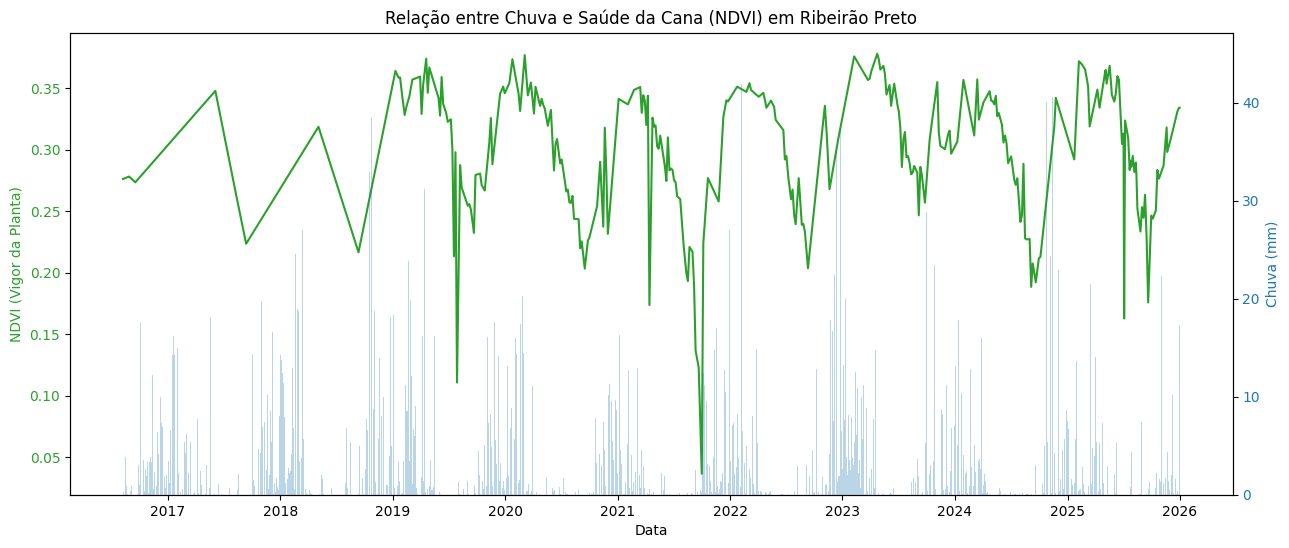

In [20]:
# Criando um gráfico com dois eixos Y
fig, ax1 = plt.subplots(figsize=(15, 6))

# Eixo 1: NDVI
color = 'tab:green'
ax1.set_xlabel('Data')
ax1.set_ylabel('NDVI (Vigor da Planta)', color=color)
ax1.plot(df_final.index, df_final['ndvi'], color=color, label='NDVI')
ax1.tick_params(axis='y', labelcolor=color)

# Eixo 2: Chuva
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Chuva (mm)', color=color)
ax2.bar(df_final.index, df_final['Chuva_mm'], color=color, alpha=0.3, label='Chuva')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Relação entre Chuva e Saúde da Cana (NDVI) em Ribeirão Preto')
plt.show()

Este gráfico ilustra como períodos sem chuva são prejudiciais para a saúde da cana, o que reforça nossa capacidade de previsibilidade em busca de melhores resultados.

# 3 Preparando o terreno  e aplicando técnicas de Machine Learning

In [21]:
# Criando uma cópia para preservar os dados originais
df_ml = df_final.copy()

# 1. Acumulados de Chuva (O mais importante para o Agro)
# A planta responde ao que choveu no último mês
df_ml['chuva_acumulada_15d'] = df_ml['Chuva_mm'].rolling(window=15).sum()
df_ml['chuva_acumulada_30d'] = df_ml['Chuva_mm'].rolling(window=30).sum()

# 2. Médias Móveis de Temperatura e Umidade do Solo
# Indica se o solo tem se mantido úmido ou seco nas últimas semanas
df_ml['media_temp_7d'] = df_ml['Temperatura_Media'].rolling(window=7).mean()
df_ml['media_umidade_solo_15d'] = df_ml['Umidade_Solo'].rolling(window=15).mean()

# 3. Diferença de NDVI (Tendência)
# O NDVI está subindo ou descendo em relação a ontem?
df_ml['tendencia_ndvi'] = df_ml['ndvi'].diff()

# 4. Variáveis de Calendário (Sazonalidade)
df_ml['mes'] = df_ml.index.month
df_ml['dia_do_ano'] = df_ml.index.dayofyear

# Como criamos janelas móveis, os primeiros dias ficarão com valores nulos (NaN)
# Vamos removê-los para o modelo não dar erro
df_ml = df_ml.dropna()

print("Novas colunas criadas com sucesso!")
print(f"Colunas agora: {df_ml.columns.tolist()}")
display(df_ml.head())

Novas colunas criadas com sucesso!
Colunas agora: ['Temperatura_Media', 'Chuva_mm', 'Umidade_Relativa', 'Radiação_Solar', 'Umidade_Solo', 'ndvi', 'chuva_acumulada_15d', 'chuva_acumulada_30d', 'media_temp_7d', 'media_umidade_solo_15d', 'tendencia_ndvi', 'mes', 'dia_do_ano']


,Temperatura_Media,Chuva_mm,Umidade_Relativa,Radiação_Solar,Umidade_Solo,ndvi,chuva_acumulada_15d,chuva_acumulada_30d,media_temp_7d,media_umidade_solo_15d,tendencia_ndvi,mes,dia_do_ano
Data,,,,,,,,,,,,,
2016-09-06,23.09,1.07,63.51,6.20,0.43,0.276169,5.25,34.35,23.090000,0.513333,-0.000236,9,250
2016-09-07,21.54,0.10,66.58,13.09,0.42,0.275933,5.24,34.45,23.080000,0.500667,-0.000236,9,251
2016-09-08,21.27,0.00,51.88,24.12,0.40,0.275697,5.24,34.45,22.921429,0.487333,-0.000236,9,252
2016-09-09,20.83,0.04,45.31,22.88,0.38,0.275461,5.28,34.19,22.344286,0.472667,-0.000236,9,253
2016-09-10,24.71,0.00,46.78,21.78,0.36,0.275225,5.28,34.19,22.531429,0.457333,-0.000236,9,254


Sem essas colunas: O modelo tentaria adivinhar o NDVI de hoje olhando apenas se choveu hoje. Se choveu 50mm mas o solo estava seco há meses, a planta não fica verde imediatamente.

Com essas colunas: O modelo agora "enxerga" o histórico. Ele sabe que se a chuva_acumulada_30d é alta e a media_umidade_solo_15d está boa, o NDVI tem uma tendência de subida.

## 3 Separando os dados e testando a precisão do modelo

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Definindo o Target (Alvo) com um "Shift" de 7 dias para o futuro
df_ml['target_ndvi_7d'] = df_ml['ndvi'].shift(-7)
df_ml = df_ml.dropna() # Remove os últimos 7 dias que não têm "futuro" para comparar

# 2. Definindo Features (X) e Target (y)
X = df_ml.drop(columns=['target_ndvi_7d'])
y = df_ml['target_ndvi_7d']

# 3. Separação Temporal (Treino até 2024, Teste 2025)
split_date = '2025-01-01'
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]
X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

# 4. Treinamento
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# 5. Previsão e Avaliação
previsoes = modelo.predict(X_test)

mae = mean_absolute_error(y_test, previsoes)
r2 = r2_score(y_test, previsoes)

print(f"Erro Médio Absoluto (MAE): {mae:.4f}")
print(f"R² Score (Acurácia): {r2:.4f}")

Erro Médio Absoluto (MAE): 0.0160
R² Score (Acurácia): 0.7133


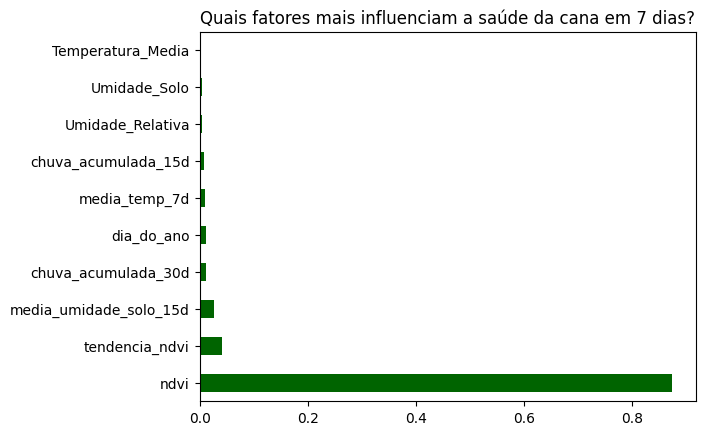

In [23]:
# Verificando a importância das variáveis
importancia = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)
importancia.head(10).plot(kind='barh', color='darkgreen')
plt.title('Quais fatores mais influenciam a saúde da cana em 7 dias?')
plt.show()

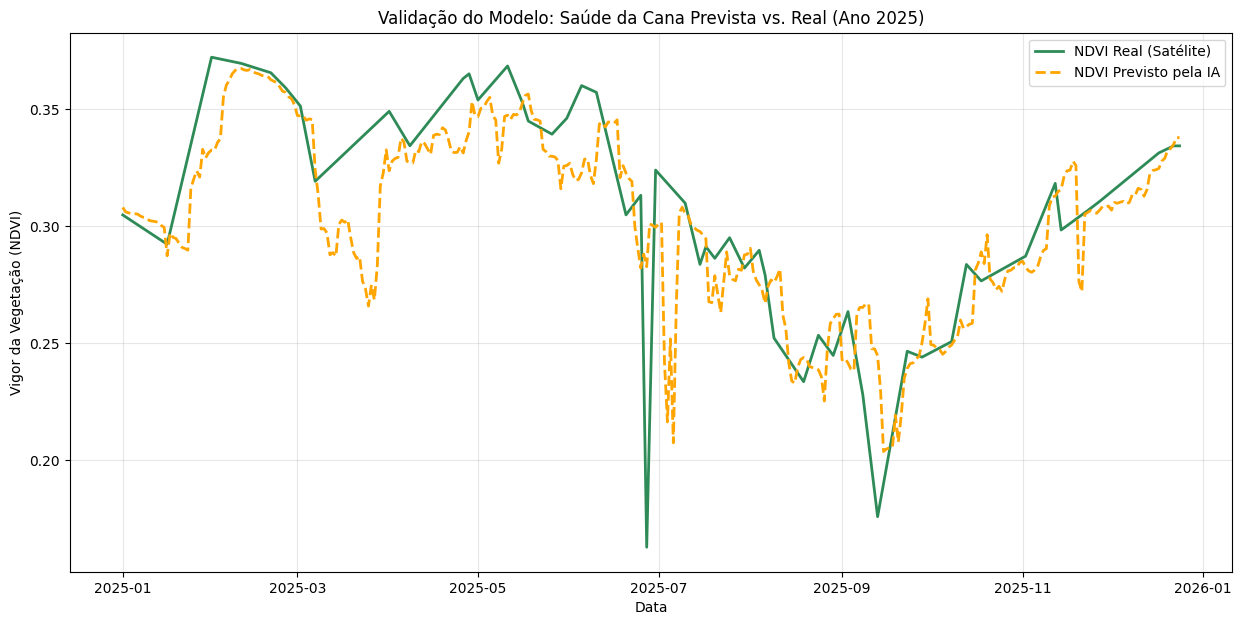

In [24]:
plt.figure(figsize=(15, 7))

# Plotando os valores reais
plt.plot(y_test.index, y_test.values, label='NDVI Real (Satélite)', color='seagreen', linewidth=2)

# Plotando as previsões da IA
plt.plot(y_test.index, previsoes, label='NDVI Previsto pela IA', color='orange', linestyle='--', linewidth=2)

plt.title('Validação do Modelo: Saúde da Cana Prevista vs. Real (Ano 2025)')
plt.xlabel('Data')
plt.ylabel('Vigor da Vegetação (NDVI)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4 Entrega

In [25]:
def gerar_conselho_agronomico(ndvi_atual, ndvi_previsto, chuva_30d):
    diferenca = ndvi_previsto - ndvi_atual
    
    if diferenca > 0.02:
        status = "Melhora significativa no vigor."
        acao = "Condições ideais. Monitorar maturação para planejamento de colheita."
    elif diferenca < -0.02:
        status = "Alerta: Declínio de vigor detectado."
        if chuva_30d < 50:
            acao = "Estresse hídrico provável. Iniciar irrigação suplementar imediatamente."
        else:
            acao = "Risco de pragas ou doenças. Realizar inspeção de campo."
    else:
        status = "Estabilidade no vigor vegetativo."
        acao = "Manter cronograma de manejo atual."
        
    return f"ANÁLISE: {status}\nRECOMENDAÇÃO: {acao}"

print("Função do Agente Agrônomo carregada com sucesso!")

Função do Agente Agrônomo carregada com sucesso!


In [26]:
#1. Pegar a data mais recente e os dados correspondentes
data_atual = X_test.index[-1]
dados_atuais = X_test.iloc[-1]
previsao_futura = previsoes[-1]

# 2. Calcular a variação percentual esperada
variacao_percentual = ((previsao_futura - dados_atuais['ndvi']) / dados_atuais['ndvi']) * 100

# 3. Gerar o conselho usando a função que criamos
conselho = gerar_conselho_agronomico(dados_atuais['ndvi'], previsao_futura, dados_atuais['chuva_acumulada_30d'])

print(f"--- RELATÓRIO DE MONITORAMENTO: {data_atual.strftime('%d/%m/%Y')} ---")
print(f"Vigor Atual (NDVI): {dados_atuais['ndvi']:.3f}")
print(f"Previsão para daqui a 7 dias: {previsao_futura:.3f} ({variacao_percentual:+.2f}%)")
print("-" * 50)
print(conselho)

--- RELATÓRIO DE MONITORAMENTO: 24/12/2025 ---
Vigor Atual (NDVI): 0.331
Previsão para daqui a 7 dias: 0.338 (+1.96%)
--------------------------------------------------
ANÁLISE: Estabilidade no vigor vegetativo.
RECOMENDAÇÃO: Manter cronograma de manejo atual.


In [27]:
import joblib
import os

caminho_projeto = r'F:\projetos_python\Projeto Agro 2026 - Sistemas de Monitoramento e Previsão Inteligente'

# Pegamos as colunas que você usou no X_train (o que o modelo de fato aprendeu)
colunas_treino = X_train.columns.tolist()

# Criamos o arquivo apenas com essas colunas + o próprio ndvi original para o gráfico
df_dashboard = df_ml[colunas_treino].copy()
# Adicionamos o ndvi original se ele não estiver na lista (para plotar o gráfico real)
if 'ndvi' not in df_dashboard.columns:
    df_dashboard['ndvi'] = df_ml['ndvi']

# Salva
df_dashboard.to_csv(os.path.join(caminho_projeto, "dados_para_dashboard.csv"))
joblib.dump(modelo, os.path.join(caminho_projeto, "modelo_agro_treinado.pkl"))

print("Arquivos sincronizados com sucesso!")

Arquivos sincronizados com sucesso!


### Compressão do modelo para upload no github

In [28]:
caminho_projeto = r'F:\projetos_python\Projeto Agro 2026 - Sistemas de Monitoramento e Previsão Inteligente'

# O parâmetro 'compress=3' costuma reduzir o tamanho em até 70% sem perder precisão
joblib.dump(modelo, os.path.join(caminho_projeto, "modelo_agro_treinado.pkl"), compress=3)

print("Modelo compactado salvo!")

Modelo compactado salvo!
